# STG_TEMP_MAX_2Pass

## Setup

In [ ]:
# If necessary:
import os
os.remove('snorkel.db')

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

## Parsing

In [ ]:
from snorkel import SnorkelSession
session = SnorkelSession()

### Define Parser

In [11]:
import os
from snorkel.parser import CorpusParser, HTMLParser, OmniParser
from snorkel.utils import get_ORM_instance
from snorkel.queries import split_corpus

html_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_html/'
pdf_path  = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware100_pdf/'
doc_parser = HTMLParser(path=html_path)
context_parser = OmniParser(pdf_path=pdf_path, session=session, visual=True)
visual_linker = context_parser.vizlink
cp = CorpusParser(doc_parser, context_parser, max_docs=100) 

### Run Parser

In [ ]:
%time corpus = cp.parse_corpus(name='Hardware', session=session)

session.add(corpus)
session.commit()

### Split Corpus

In [ ]:
from snorkel.models import Corpus

corpus = get_ORM_instance(Corpus, session, 'Hardware')
split_corpus(session, corpus, train=0.8, development=0.2, test=0, seed=3)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ corpus snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

In [ ]:
from snorkel.models import candidate_subclass

Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])

### Define Matchers

In [ ]:
from snorkel.matchers import RegexMatchSpan, Union

eeca_rgx = ur'([b]{1}[abcdefklnpqruyz]{1}[\swxyz]?[0-9]{3,5}[\s]?[A-Z]{0,2}[\/]?[A-Z]{0,2}[0-9]?[A-Z]?([(\-|\u2010|\u2011|\u2012|\u2013|\u2014|\u2212)][A-Z0-9]{1,7})?([(\-|\u2010|\u2011|\u2012|\u2013|\u2014|\u2212)][A-Z0-9]{1,2})?)'
eeca_matcher = RegexMatchSpan(rgx=eeca_rgx, longest_match_only=True)
jedec_rgx = '([123]N\d{3,4}[A-Z]{0,5}[0-9]?[A-Z]?)'
jedec_matcher = RegexMatchSpan(rgx=jedec_rgx, longest_match_only=True)
jis_rgx = '(2S[abcdefghjkmqrstvz]{1}[\d]{2,4})'
jis_matcher = RegexMatchSpan(rgx=jis_rgx, longest_match_only=True)
others_rgx = '((NSVBC|SMBT|MJ|MJE|MPS|MRF|RCA|TIP|ZTX|ZT|TIS|TIPL|DTC|MMBT|PZT){1}[\d]{2,4}[A-Z]{0,3}([-][A-Z0-9]{0,6})?([-][A-Z0-9]{0,1})?)'
others_matcher = RegexMatchSpan(rgx=others_rgx, longest_match_only=True)
# parts_rgx = '|'.join([eeca_rgx, jedec_rgx, jis_rgx, others_rgx])
parts_matcher = Union(eeca_matcher, jedec_matcher, jis_matcher, others_matcher)

temp_matcher = RegexMatchSpan(rgx=r'1[4-6]0', longest_match_only=False)

In [ ]:
# import re
# part_finder = re.compile(parts_rgx, re.I)
# print any([part_finder.match(x) for x in ['blue', 'red', 'black', 'green']])
# print any([part_finder.match(x) for x in ['blue', 'red', 'BC546A', 'green']])

### Define ContextSpaces

In [ ]:
from hardware_utils import get_gold_dict, get_first_pass_dict, OmniNgramsPart, OmniNgramsTemp, merge_two_dicts
from collections import defaultdict
from snorkel.candidates import OmniNgrams
from snorkel.utils import get_ORM_instance
from snorkel.models import Corpus

eeca_suffix = '^(A|B|C|-16|-25|-40|16|25|40)$'
suffix_matcher = RegexMatchSpan(rgx=eeca_suffix, ignore_case=False)
suffix_ngrams = OmniNgrams(n_max=1)
part_ngrams = OmniNgramsPart(n_max=5)


dev_corpus = get_ORM_instance(Corpus, session, "Hardware Development")

train_corpus = get_ORM_instance(Corpus, session, "Hardware Training")


parts_dev, s_dev, p_dev = get_first_pass_dict(dev_corpus.documents, parts_matcher=parts_matcher, part_ngrams=part_ngrams, suffix_matcher=suffix_matcher, suffix_ngrams=suffix_ngrams)      

parts_train, s_train, p_train = get_first_pass_dict(train_corpus.documents, parts_matcher=parts_matcher, part_ngrams=part_ngrams, suffix_matcher=suffix_matcher, suffix_ngrams=suffix_ngrams)  

parts_by_doc = merge_two_dicts(parts_dev, parts_train)

In [ ]:
# import pickle
# filename = '1stpass.pkl'
# with open(filename, 'w') as f:
#     pickle.dump(parts_by_doc, f)
    
import pickle
filename = '1stpass.pkl'
with open(filename, 'r') as f:
    parts_by_doc = pickle.load(f)


In [ ]:
from hardware_utils import OmniNgramsPart, OmniNgramsTemp

part_ngrams = OmniNgramsPart(parts_by_doc=parts_by_doc, n_max=5)

# TODO: This is missing the current represented as an Amp rather than a milliamp
temp_ngrams = OmniNgramsTemp(n_max=2)

### Define Throttler

In [ ]:
from snorkel.lf_helpers import *

def part_throttler((part_span, attr_span)):
    """
    Keep only those candidates where both spans are on the same page and
    either aligned in the same table (visually or structurally) or the part is global.
    """
    # TODO: Write this in an easier to tweak way. No reason to try and
    # cram it all into a single return statement.
#     return(
#         same_page((part_span, attr_span)) or
#         (part_span.parent.table is None))
    
    # Filter out things like BC546-BC550 that pass through otherwise
    text = part_span.get_span()
    if text.count('-') == 1:
        split = text.split('-')
        if len(split[0]) == len(split[1]):
            return False

    return True

#     if (not part_span.has_visual_features() or not attr_span.has_visual_features()):
#         import pdb; pdb.set_trace()

#     return(part_span.parent.table is None or
#            same_table((part_span, attr_span)))


### Run CandidateExtractor

In [ ]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance


ce = CandidateExtractor(Part_Temp, 
                        [part_ngrams, temp_ngrams], 
                        [parts_matcher, temp_matcher],
                        throttler=part_throttler)

for corpus_name in ['Hardware Training', 'Hardware Development']:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = ce.extract(\
        corpus.documents, corpus_name + ' Candidates', session)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

### Assess Recall

In [ ]:
from hardware_utils import entity_level_total_recall, most_common_document, get_gold_dict
from snorkel.utils import get_ORM_instance
from snorkel.models import Candidate, Corpus

all_candidates = session.query(Candidate).all()
gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'

corpus = get_ORM_instance(Corpus, session, 'Hardware')
(tp, fp, fn) = entity_level_total_recall(
    all_candidates, gold_file, 'stg_temp_max', corpus=corpus, relation=True, integerize=True)
print len(tp)
print len(fp)
print len(fn)

In [ ]:
from pprint import pprint
fns = list(fn)
pprint(sorted(fns)[:40])
pprint(sorted(parts_by_doc["PHGLS18216-1"]))

In [ ]:
# corpus = get_ORM_instance(Corpus, session, 'Hardware Training')
# for document in corpus.documents:
# #     print document.name
#     if document.name == 'MOTOS03160-1':
#         doc = document
# print doc

In [ ]:
# for c in all_candidates:
#     if c.part.get_span()=='BC183' and c.part.parent.document.name=='MOTOS03160-1':
#         print c

In [ ]:
# for phrase in doc.phrases:
#     if 'BC183' in phrase.words:
#         print phrase

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [ ]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ candidates snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])

In [ ]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
for set_name in ['Training', 'Development']:
    candidate_set_name = 'Hardware %s Candidates' % set_name
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % set_name
    annotation_key_name = 'Hardware %s Labels -- Gold' % set_name
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file, \
                           attrib='stg_temp_max')
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [ ]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ labels snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])

### Extract Features

In [ ]:
from snorkel.models import CandidateSet
from snorkel.fast_annotations import FeatureManager
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Training Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Development Candidates')

feature_manager = FeatureManager()
%time F_train = feature_manager.create(session, train, 'Train Features')
%time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

In [ ]:
# If necessary:
import os
os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [ ]:
# If necessary
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ featurized snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
dev = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates').one()

### Define LFs

In [ ]:
from snorkel.fast_annotations import LabelManager
from snorkel.lf_helpers import *
label_manager = LabelManager()

LFs = []


###################################################################
# POSITIVE
###################################################################
def LF_storage_row(c):
    return 1 if 'storage' in get_row_ngrams(c.temp) else 0
LFs.append(LF_storage_row)

def LF_junction_row(c):
    return 1 if 'junction' in get_row_ngrams(c.temp) else 0
LFs.append(LF_junction_row)

def LF_operating_row(c):
    return 1 if 'operating' in get_row_ngrams(c.temp) else 0
LFs.append(LF_operating_row)

def LF_temperature_row(c):
    return 1 if 'temperature' in get_row_ngrams(c.temp) else 0
LFs.append(LF_temperature_row)

def LF_to_left(c):
    return 1 if 'to' in get_left_ngrams(c.temp, window=2) else 0
LFs.append(LF_to_left)

def LF_negative_left(c):
    return 1 if any([re.match(r'-\s*\d+', ngram) for ngram in get_left_ngrams(c.temp, window=4)]) else 0
LFs.append(LF_negative_left)

def LF_part_type_aligned(c):
    return 1 if 'type' in get_col_ngrams(c.part) else 0
LFs.append(LF_part_type_aligned)


def LF_tstg_row(c):
    return 1 if overlap(
        ['tstg','stg','ts'], 
        list(get_row_ngrams(c.temp))) else 0
LFs.append(LF_tstg_row)
pos_keys = set(['tstg', 'stg']) # 'value', 'rating'


###################################################################
# NEGATIVE
###################################################################

def LF_not_temp_relevant(c):
    return -1 if not overlap(
        ['storage','temperature','tstg','ts','stg'],
        list(get_aligned_ngrams(c.temp))) else 0
LFs.append(LF_not_temp_relevant)

# def LF_temp_outside_table(c):
#     return -1 if c.temp.parent.table is None else 0
# LFs.append(LF_temp_outside_table)

def LF_too_many_numbers_row(c):
    num_numbers = list(get_row_ngrams(c.temp, attrib="ner_tags")).count('number')
    return -1 if num_numbers >= 3 else 0
LFs.append(LF_too_many_numbers_row)

def LF_high_table_num(c):
    return -1 if (c.temp.parent.table and
        c.temp.parent.table.position > 4) else 0
LFs.append(LF_high_table_num)

def LF_equals_in_row(c):
    return -1 if overlap('=', get_row_ngrams(c.temp)) else 0
LFs.append(LF_equals_in_row)

complementary_keys = set(['empfohlene', 'recommended','complement', 'complementary', 'full', 'line', 'production'])
def LF_complementary_keywords_part(c):
    return -1 if overlap(complementary_keys, get_aligned_ngrams(c.part, infer=True)) else 0
LFs.append(LF_complementary_keywords_part)

# For PHGLS25601-1
def LF_part_too_far_right(c):
    return -1 if (c.part.parent.col_start > 3) else 0
LFs.append(LF_part_too_far_right)

def LF_part_neighbor_phrase_complementary(c):
    neighbor_ngrams = set(get_neighbor_phrase_ngrams(c.part))
    if (overlap(complementary_keys, neighbor_ngrams)):
        return -1
    
    return 0
LFs.append(LF_part_neighbor_phrase_complementary)

# def LF_horiz_complementary(c):
#     horiz_ngrams = set(get_horz_aligned_ngrams(c.part))
#     if (overlap(complementary_keys, horiz_ngrams)):
#         return -1
#     return 0
# LFs.append(LF_horiz_complementary)

# def LF_vert_complementary(c):
#     vert_ngrams = set(get_vert_aligned_ngrams(c.part))
#     if (overlap(complementary_keys, vert_ngrams)):
#         return -1
#     return 0
# LFs.append(LF_vert_complementary)

def LF_i_in_row(c):
    return -1 if overlap('i', get_row_ngrams(c.temp)) else 0
LFs.append(LF_i_in_row)

def LF_collector_aligned(c):
    return -1 if overlap(
        ['collector', 'collector-current', 'collector-base', 'collector-emitter'],
        list(get_aligned_ngrams(c.temp))) else 0
LFs.append(LF_collector_aligned)

def LF_current_aligned(c):
    ngrams = get_aligned_ngrams(c.temp)
    return -1 if overlap(
        ['current', 'dc', 'ic'],
        list(get_aligned_ngrams(c.temp))) else 0
LFs.append(LF_current_aligned)

def LF_voltage_row_temp(c):
    ngrams = get_aligned_ngrams(c.temp)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.temp))) else 0
LFs.append(LF_voltage_row_temp)

def LF_voltage_row_part(c):
    ngrams = get_aligned_ngrams(c.part)
    return -1 if overlap(
        ['voltage', 'cbo', 'ceo', 'ebo', 'v'],
        list(get_aligned_ngrams(c.temp))) else 0
LFs.append(LF_voltage_row_part)

def LF_test_condition_aligned(c):
    return -1 if overlap(
        ['test', 'condition'],
        list(get_aligned_ngrams(c.temp))) else 0
LFs.append(LF_test_condition_aligned)

def LF_typ_row(c):
    return -1 if overlap(
        ['typ', 'typ.'],
        list(get_row_ngrams(c.temp))) else 0
LFs.append(LF_typ_row)

def LF_complement_left_row(c):
    return -1 if 'complement' in get_row_ngrams(c.part) else 0
LFs.append(LF_complement_left_row)

### Apply LFs

In [ ]:
%time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

### Assess LF accuracy

In [ ]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()
%time L_train.lf_stats(train_gold)

In [ ]:
# If necessary
import os
os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [1]:
# If necessary:
import os
os.remove('snorkel.db');
os.system('cp snorkel.db\ features snorkel.db');

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

from snorkel import SnorkelSession
session = SnorkelSession()

from snorkel.models import candidate_subclass
Part_Temp = candidate_subclass('Part_Temp', ['part','temp'])

In [2]:
from snorkel.fast_annotations import FeatureManager, LabelManager
from snorkel.models import CandidateSet
train = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates').one()
dev = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates').one()

feature_manager = FeatureManager()
%time F_train = feature_manager.load(session, train, 'Train Features')
%time F_dev = feature_manager.load(session, dev, 'Train Features')

label_manager = LabelManager()
%time L_train = label_manager.load(session, train, 'LF Labels')

CPU times: user 1min 19s, sys: 1.56 s, total: 1min 20s
Wall time: 1min 20s
CPU times: user 52.7 s, sys: 1.19 s, total: 53.9 s
Wall time: 53.8 s
CPU times: user 23.2 s, sys: 424 ms, total: 23.6 s
Wall time: 23.7 s


In [3]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=100000, rate=1e-6)
%time gen_model.save(session, 'Generative Params')
train_marginals = gen_model.marginals(L_train)

/home/lwhsiao/repos/snorkel/.virtualenv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	115717
Features:			23
Begin training for rate=1e-06, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.451890
	Learning epoch = 250	Gradient mag. = 0.475573
	Learning epoch = 500	Gradient mag. = 0.475473
	Learning epoch = 750	Gradient mag. = 0.475372
	Learning epoch = 1000	Gradient mag. = 0.475272
	Learning epoch = 1250	Gradient mag. = 0.475171
	Learning epoch = 1500	Gradient mag. = 0.475071
	Learning epoch = 1750	Gradient mag. = 0.474970
	Learning epoch = 2000	Gradient mag. = 0.474870
	Learning epoch = 2250	Gradient mag. = 0.474769
	Learning epoch = 2500	Gradient mag. = 0.474669
	Learning epoch = 2750	Gradient mag. = 0.474568
	Learning epoch = 3000	Gradient mag. = 0.474468
	Learning epoch = 3250	Gradient mag. = 0.474367
	Learning epoch = 3500	Gradient mag. = 0.474267
	Learning epoch = 3750	Gradient mag. = 0.474166
	Learning epoch = 4000	Gradient mag. = 0.474066
	Learning epoch = 4250	Gradient mag. = 0.473965
	Learning epoch = 4500	Gradient mag. = 0.473864
	Le

In [4]:
from snorkel.learning import LogReg

disc_model = LogReg()
disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)
%time disc_model.save(session, "Discriminative Params")

Training marginals (!= 0.5):	107880
Features:			10007
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 74776.717839	Gradient magnitude = 71338.585717
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 51558.661468	Gradient magnitude = 16496.898934
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 79925.479675	Gradient magnitude = 35551.192320
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 96242.564327	Gradient magnitude = 45986.449833
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 46261.537961	Gradient magnitude = 25848.495171
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 50383.720663	Gradient magnitude = 20561.546112
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 43928.736581	Gradient magnitude = 20310.589594
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 43426.306383	Gradient magnitude = 26040.736206
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 40730.262650	Gradi

Calibration plot:


/home/lwhsiao/repos/snorkel/.virtualenv/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


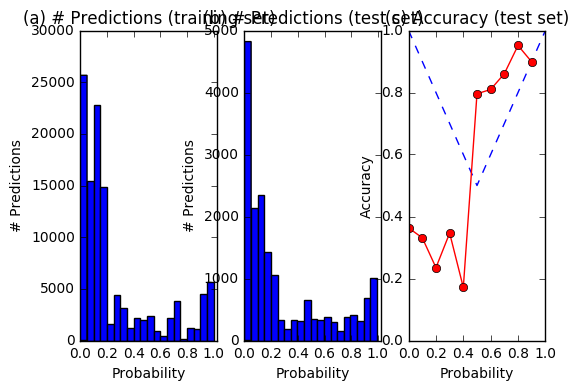

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.287946773944
Neg. class accuracy: 0.892992613296
Corpus Precision 0.874
Corpus Recall    0.288
Corpus F1        0.433
----------------------------------------
TP: 3722 | FP: 536 | TN: 4473 | FN: 9204

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.287946773944
Neg. class accuracy: 0.892992613296
Corpus Precision 0.874
Corpus Recall    0.288
Corpus F1        0.433
----------------------------------------
TP: 3722 | FP: 536 | TN: 4473 | FN: 9204



In [5]:
train_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Training Candidates -- Gold').one()

dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Development Candidates -- Gold').one()

from snorkel.models import CandidateSet
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Development Labels -- Gold')

tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [6]:
from snorkel.models import Corpus
from snorkel.utils import get_ORM_instance
from hardware_utils import entity_level_f1
import os

dev_corpus = get_ORM_instance(Corpus, session, 'Hardware Development')

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/hardware_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Development').one()
(TP, FP, FN) = entity_level_f1(tp, fp, tn, fn, gold_file, dev_corpus, 'stg_temp_max')

Scoring on Entity-Level Gold Data
Corpus Precision 0.745
Corpus Recall    0.917
Corpus F1        0.822
----------------------------------------
TP: 155 | FP: 53 | FN: 14



In [7]:
from pprint import pprint
FN_list = sorted(list(FN))
FP_list = sorted(list(FP))
TP_list = sorted(list(TP))
# pprint(FN_list[:])
pprint(FP_list[:100])
# pprint(TP_list[:10])

[(u'2N3906-D', u'1N916', u'150'),
 (u'2N3906-D', u'2N390D', u'150'),
 (u'BC546-BC548C(TO-92)', u'BC546-BC548C', u'150'),
 (u'BC546-BC548C(TO-92)', u'BC546THRU', u'150'),
 (u'DISES00645-1', u'BC807K', u'150'),
 (u'DISES00645-1', u'BC807K-16', u'150'),
 (u'DISES00645-1', u'BC807K-25', u'150'),
 (u'DISES00645-1', u'BC807K-40', u'150'),
 (u'DISES00645-1', u'BC807KC', u'150'),
 (u'DISES00645-1', u'BC808K', u'150'),
 (u'DISES00645-1', u'BC808K-16', u'150'),
 (u'DISES00645-1', u'BC808K-25', u'150'),
 (u'DISES00645-1', u'BC808K-40', u'150'),
 (u'DISES00645-1', u'BC808KC', u'150'),
 (u'DISES00645-1', u'BC817K-16C', u'150'),
 (u'DISES00645-1', u'BC817K-25C', u'150'),
 (u'DISES00645-1', u'BC817K-40C', u'150'),
 (u'DISES00645-1', u'BC817KC', u'150'),
 (u'DISES00645-1', u'BC818K-16C', u'150'),
 (u'DISES00645-1', u'BC818K-25C', u'150'),
 (u'DISES00645-1', u'BC818K-40C', u'150'),
 (u'DISES00645-1', u'BC818KC', u'150'),
 (u'INFINEON-BC857SERIES_BC858SERIES_BC859SERIES_BC860SERIES-DS-V01_01-EN',
  u'BC

In [8]:
import pickle
filename = 'eval.pkl'
with open(filename, 'w') as f:
    pickle.dump((FN_list, FP_list, TP_list), f)
    
# import pickle
# filename = 'eval.pkl'
# with open(filename, 'r') as f:
#     FN_list, FP_list, TP_list = pickle.load(f)

In [ ]:
# docs = set()
# for doc in corpus.documents:
#     docs.add(doc.name.upper())
# pprint(docs)

In [ ]:
# import itertools
# docs = set()
# for f in itertools.chain.from_iterable([tp, tn, fp, fn]):
#     docs.add(f.part.parent.document.name.upper())
# #     if f.part.parent.document.name.upper() == 'AUKCS04635-1':
# #         print f
# pprint(docs)

In [9]:
from hardware_utils import entity_to_candidates, part_error_analysis

# disc_model.get_feature_weights(F_dev)

entity = FP_list[7]
matches = entity_to_candidates(entity, dev)
print "Entity: (%d matches)" % len(matches)
print entity

Entity: (2 matches)
(u'DISES00645-1', u'BC807K-40', u'150')


In [10]:
match = matches[0]
print match.part

ImplicitSpan("BC807K-40", parent=50566, words=[0,0], position=[1])


In [ ]:
from snorkel.lf_helpers import *

ngrams = set(get_horz_aligned_ngrams(match.part))
from pprint import pprint
pprint(ngrams)

from snorkel.visual import *
# print(visual_linker.document)
visual_linker.parse_visual(match.part.parent.document)

visual_linker.display_words(target=["BC808K", "complementary", "Empfohlene"], page_num=2)


set([])
Boxes per page: total (unique)
Page 2: 2 (2)


In [ ]:
def LF_part_neighbor_phrase_complementary(c):
    neighbor_ngrams = set(get_neighbor_phrase_ngrams(match.part))
    if (overlap(complementary_keys, neighbor_ngrams)):
        return -1
    
    return 0

LF_part_neighbor_phrase_complementary(match)

In [ ]:
results = []
for lf in LFs:
    results.append(lf.__name__, lf(candidate))

In [ ]:
print F_train.shape
print F_dev.shape

In [ ]:
import os
os.system('cp snorkel.db snorkel.db\ final');